In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr

In [2]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [4]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

#m21[i] = -2.5*np.log10(F_av_ESN[i])+17.40
#m21_e[i] = (2.5/np.log(10))*(eF_av_ESN[i]/F_av_ESN[i])
F21 = 10**(-0.4*(df.m21-17.40))   # HI 21cm Flux [Jy.km/s]
eF21 = (df.em21/(2.5/np.log(10)))*F21
df['F21'] = F21
df['eF21'] = eF21
df['Mass_HI'] = 2.356E5 * F21 * (df.D75**2)



print(df.columns)
print(len(df))

df.head()

Index(['PGC', 'Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1',
       ...
       'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi', 'F21',
       'eF21', 'Mass_HI'],
      dtype='object', length=120)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PGC,Name,Vhel,Vls,u,g,r,i,z,w1,...,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,F21,eF21,Mass_HI
0,2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,...,-34.024557,-34.024557,-34.024557,-34.024557,-22.164557,-21.534557,0.00,4.729334,0.805837,4.537307e+09
1,4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,...,-18.127026,-18.387026,-18.597026,-18.647026,-17.657026,-17.297026,0.47,1.926637,0.134862,1.392470e+09
2,12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,...,-34.620362,-34.620362,-34.620362,-34.620362,-21.020362,-20.420362,0.00,3.400948,0.579492,5.648331e+09
3,16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,...,-19.921429,-20.421429,-20.701429,-20.881429,-20.301429,-19.611429,0.78,1.194538,0.203539,1.451933e+09
4,55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,...,-18.364131,-18.574131,-18.674131,-18.724131,-17.714131,-17.294131,0.31,4.541507,0.317899,3.863918e+09


In [5]:
def linear(x, m, b):
    
    return m*x+b

3.222720666197919 10.488815000621223
2.1037182919280877 10.589535446258413


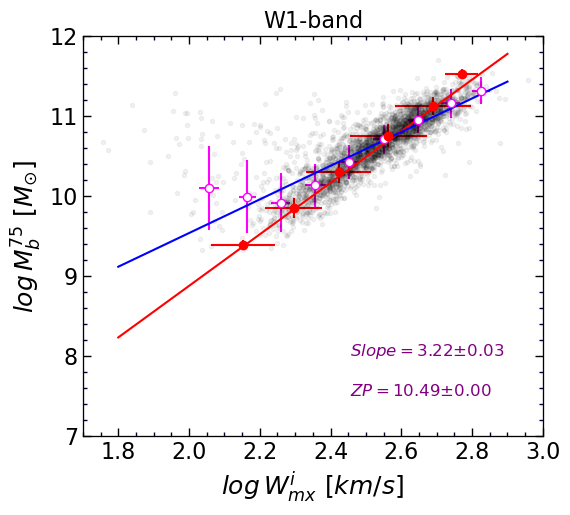

In [6]:
logMs = 2.20 - 0.4*df['M1_75']
df['Mass_star'] = 10**logMs
df['Mb'] = df['Mass_star'] + 1.33*df['Mass_HI'] 
df['logMass'] = np.log10(df.Mb.values)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)&(df.Vmod<20000)].dropna()

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMass.values
Vmod = dff.Vmod.values

ln10 = np.log(10)
dMs = 0.4*0.05*ln10
dM21 = 2.356E5 * dff.eF21 * (dff.D75**2)
dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
dlogMb = dMb/dff.Mb/ln10

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05)
# ax.plot(logW[Vmod<7000], logMass[Vmod<7000], 'b.', alpha=0.3)

w = np.linspace(1.8,2.9,100)

# ax.plot(w, 3.8*(w-2.5) + 10.3, 'r-')


fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(dlogMb/3.18)**2))
m, b = fit[0], fit[1]
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]    
m0 = 1./m
b0 = -b/m
dm0 = np.abs(me/m**2)
db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
ax.plot(w, m0*(w-2.5) + b0, 'r-')
print(m0,b0)


# fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
# m = fit[0]
# b = fit[1]
# ax.plot(w, m*(w-2.5)+b, 'b-')
# print(m,b)

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)].dropna()
dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMass
std = dff['delta'].std()
dff = dff[np.abs(dff.delta)<3.5*std]


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (7,12))

ax.set_title("W1-band", fontsize=16)


# fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
fit, cov = np.polyfit(logW-2.5, logMass, 1, cov=True)
m = fit[0]
b = fit[1]
ax.plot(w, m*(w-2.5)+b, 'b-')
print(m,b)

# m0=0.5*(m0+m)
# b0=0.5*(b0+b)
# ax.plot(w, m0*(w-2.5)+b0, 'g-')



X = logW
Y = logMass
for i in np.arange(2,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='magenta', ms=6, mfc='white')   
        
for i in np.arange(8,12,0.5):
    xp = []
    yp = []
    for ii in range(len(Y)):
        xi = Y[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(X[ii])
    if len(xp)>0:
        ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=np.std(yp), fmt='o', 
                    color='r', ms=6)  
        
        
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.42*Xlm[0]+0.58*Xlm[1]
y0 = 0.80*Ylm[0]+0.2*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='purple')
y0 = 0.90*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$ZP = $"+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='purple')


import copy

dff_ir = copy.deepcopy(dff)

3.0983650100396725 10.523664953215004


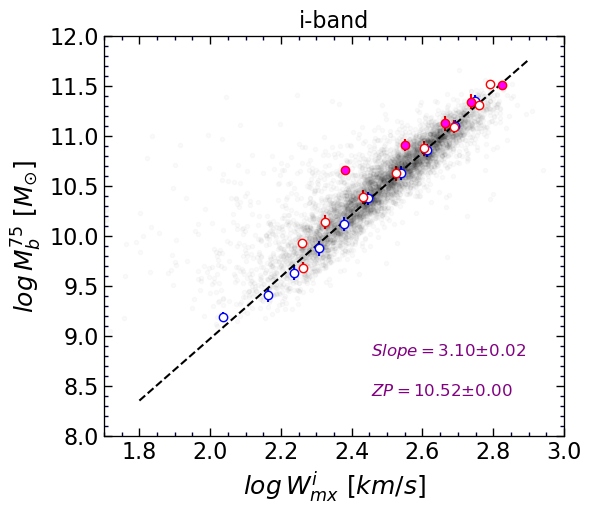

In [72]:
# logMs = 1.685 + 0.359*df.gi - 0.4*df['Mi_75'] ### ~> 2.10
logMs = 1.785 + 0.359*df.gi - 0.4*df['Mi_75']   #### upsilon ~> 2.20
# logMs = 1.835 + 0.359*df.gi - 0.4*df['Mi_75']   #### upsilon ~> 2.25
# logMs = 1.885 + 0.359*df.gi - 0.4*df['Mi_75']   #### upsilon ~> 2.30
df['Mass_star'] = 10**logMs
df['Mb'] = df['Mass_star'] + 1.33*df['Mass_HI']
df['logMass'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)&(df.Vmod<20000)].dropna()


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMass.values
Vmod = dff.Vmod.values

ln10 = np.log(10)
dMs = 0.4*0.05*ln10
dM21 = 2.356E5 * dff.eF21 * (dff.D75**2)
dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
dlogMb = dMb/dff.Mb/ln10


fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.02)




w = np.linspace(1.8,2.9,100)

# ax.plot(w, 3.8*(w-2.5) + 10.3, 'r-')


fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(dlogMb/3.15)**2))
# fit, cov = curve_fit(linear, logMass, logW-2.5)
m, b = fit[0], fit[1]
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]    
m0 = 1./m
b0 = -b/m
dm0 = np.abs(me/m**2)
db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
ax.plot(w, m0*(w-2.5) + b0, '--', color='k')
print(m0,b0)


# fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
# fit, cov = np.polyfit(logW-2.5, logMass, 1, cov=True)
# m = fit[0]
# b = fit[1]
# ax.plot(w, m*(w-2.5)+b, 'b-')
# print(m,b)

# m0=0.5*(m0+m)
# b0=0.5*(b0+b)
# ax.plot(w, m0*(w-2.5)+b0, 'g-')



# dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>5000)].dropna()
# dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMass
# std = dff['delta'].std()
# dff = dff[np.abs(dff.delta)<3.5*std]


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("i-band", fontsize=16)


# ind, = np.where((Vmod>4000)&(Vmod<5000))
# X = logW[ind]
# Y = logMass[ind]
# for i in np.arange(2,2.9,0.1):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.1:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.mean(xp), np.median(yp), yerr=0*np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='b', ms=6, mfc='white')   
        
        
# ind, = np.where((Vmod>9000)&(Vmod<11000))
# X = logW[ind]
# Y = logMass[ind]
# for i in np.arange(2,2.9,0.1):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.1:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.mean(xp), np.median(yp), yerr=0*np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='r', ms=6, mfc='white')   
        
        
        
        
# ind, = np.where((Vmod>15000))
# X = logW[ind]
# Y = logMass[ind]
# for i in np.arange(2,2.9,0.1):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.1:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.mean(xp), np.median(yp), yerr=0*np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='magenta', ms=6, mfc='white')   
                
    
ind, = np.where((Vmod>4000)&(Vmod<5000))
X = logW[ind]
Y = logMass[ind]
for i in np.arange(8,12,0.25):
    xp = []
    yp = []
    for ii in range(len(Y)):
        xi = Y[ii]
        if xi>=i and xi<i+0.25:
            xp.append(xi)
            yp.append(X[ii])
    if len(xp)>0:
        ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=0*np.std(yp), fmt='o', 
                    color='b', ms=6, mfc='white')  
        
        
ind, = np.where((Vmod>9000)&(Vmod<11000))
X = logW[ind]
Y = logMass[ind]
for i in np.arange(8,12,0.25):
    xp = []
    yp = []
    for ii in range(len(Y)):
        xi = Y[ii]
        if xi>=i and xi<i+0.25:
            xp.append(xi)
            yp.append(X[ii])
    if len(xp)>0:
        ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=0*np.std(yp), fmt='o', 
                    color='r', ms=6, mfc='white')          
        
 
ind, = np.where((Vmod>15000))
X = logW[ind]
Y = logMass[ind]
for i in np.arange(8,12,0.25):
    xp = []
    yp = []
    for ii in range(len(Y)):
        xi = Y[ii]
        if xi>=i and xi<i+0.25:
            xp.append(xi)
            yp.append(X[ii])
    if len(xp)>0:
        ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=0*np.std(yp), fmt='o', 
                    color='r', ms=6, mfc='magenta')          
        


        
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.42*Xlm[0]+0.58*Xlm[1]
y0 = 0.80*Ylm[0]+0.2*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='purple')
y0 = 0.90*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$ZP = $"+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='purple')


dff_op = copy.deepcopy(dff)

In [8]:
# logW_ir = dff_ir.lgWmxi.values
# logWe_ir = dff_ir.elgWi.values
# logMass_ir = dff_ir.logMass.values

# logW_op = dff_op.lgWmxi.values
# logWe_op = dff_op.elgWi.values
# logMass_op = dff_op.logMass.values


# logW = np.concatenate((logW_ir, logW_op))
# logWe = np.concatenate((logWe_ir, logWe_op))
# logMass = np.concatenate((logMass_ir, logMass_op))

# fig = py.figure(figsize=(5, 5), dpi=100)    
# fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
# gs = gridspec.GridSpec(1,1) ; p=0
# ax = plt.subplot(gs[p]) ; p+=1

# ax.plot(logW, logMass, 'k.', alpha=0.05)

# w = np.linspace(1.8,2.9,100)

# # ax.plot(w, 3.8*(w-2.5) + 10.3, 'r-')


# fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+0.01**2))
# # fit, cov = curve_fit(linear, logMass, logW-2.5)
# m, b = fit[0], fit[1]
# me = np.sqrt(cov[0,0])
# be = np.sqrt(cov[1,1])
# mbe = cov[1,0]    
# m0 = 1./m
# b0 = -b/m
# dm0 = np.abs(me/m**2)
# db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
# ax.plot(w, m0*(w-2.5) + b0, 'r-')
# print(m0,b0)


# ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/ M_*^{75} \/\/ [M_{\odot}]$', fontsize=18)
# set_axes(ax, (1.7,3), (7,12))

# ax.set_title("i-band", fontsize=16)




# X = logW
# Y = logMass
# for i in np.arange(2,2.9,0.1):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.1:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='magenta', ms=6, mfc='white')   
        
# for i in np.arange(8,12,0.5):
#     xp = []
#     yp = []
#     for ii in range(len(Y)):
#         xi = Y[ii]
#         if xi>=i and xi<i+0.5:
#             xp.append(xi)
#             yp.append(X[ii])
#     if len(xp)>0:
#         ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=np.std(yp), fmt='o', 
#                     color='r', ms=6)  
        
        
# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.42*Xlm[0]+0.58*Xlm[1]
# y0 = 0.80*Ylm[0]+0.2*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='purple')
# y0 = 0.90*Ylm[0]+0.10*Ylm[1]
# ax.text(x0,y0, r"$ZP = $"+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='purple')


# dff_op = copy.deepcopy(dff)

In [9]:
def getDM(mag, Wlog, F21, m0, b0, D):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - 2.25)
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D


def getDMi(mag, Wlog, F21, m0, b0, D, gi):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - (0.359*gi+1.785))
#     Mag = -2.5*(np.log10(Mb) - (0.359*gi+1.685))
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D

In [10]:
dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Vmod>4000)].dropna()
mag = dff["i***"].values
Wlog = dff.lgWmxi.values
F21 = dff.F21.values
D75 = dff.D75.values
gi = dff.gi.values

N = len(dff)
M1_fid = np.zeros(N)
print(N)
pp=0

for j in range(N):
    mag_ = mag[j]
    Wlog_ = Wlog[j]
    F21_ = F21[j]
    gi_ = gi[j]


    D = np.arange(500)
    delta = D*0.

    for i in range(500):
#         delta[i] =  D[i] - getDM(mag_, Wlog_, F21_, m0, b0, D[i])
        delta[i] =  D[i] - getDMi(mag_, Wlog_, F21_, m0, b0, D[i], gi_)


    D = D[~np.isnan(delta)]
    delta = delta[~np.isnan(delta)]

#     plt.plot(D, delta, 'k.') 
#     plt.plot([0,200], [0,0], "r:")

    try:
        D_left = np.max(D[delta<0])
        D_right = np.min(D[delta>0])
        D_root = 0.5*(D_left+D_right)
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ -  DM_fid
    except:
        D_root = D_left
        DM_fid = 5*np.log10(D_root)+25
        M1_fid[j] = mag_ -  DM_fid    
        pp+=1
    if j%1000==0:
        print(j)

print(pp)

5454
0


<ipython-input-9-2373c16e9975>:22: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - (0.359*gi+1.785))


1000
2000
3000
4000
5000
2


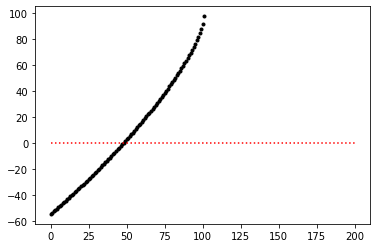

In [11]:
plt.plot(D, delta, 'k.') 
plt.plot([0,200], [0,0], "r:")

(array([  96., 1278., 1982., 1356.,  546.,  146.,   32.,   11.,    3.,
           4.]),
 array([-24.3388249 , -22.99298804, -21.64715118, -20.30131432,
        -18.95547746, -17.6096406 , -16.26380374, -14.91796688,
        -13.57213002, -12.22629316, -10.8804563 ]),
 <BarContainer object of 10 artists>)

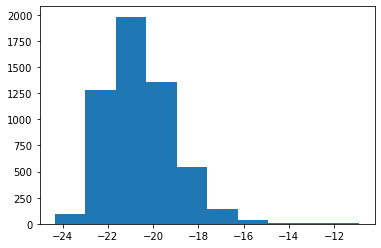

In [12]:
plt.hist(M1_fid)

In [13]:
dff['dDM'] = M1_fid - dff.Mi_75.values #- 0.00400*(np.exp((-17-M1_fid)**0.856)-1)
               
dff_ = dff.dropna()

Text(0.5, 1.0, 'BTFR: i-band')

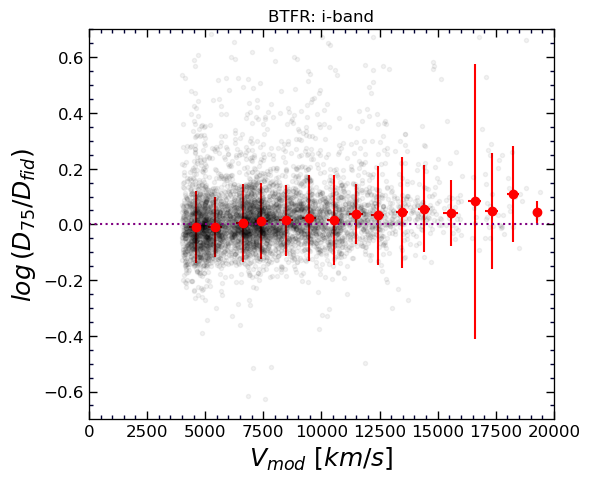

In [14]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff_.Vmod.values
Y = dff_.dDM.values/5

# Y=Y[X>4000]
# X=X[X>4000]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

ax.set_title("BTFR: i-band")

In [15]:
np.median(dff_.dDM.values)

0.053316465832079274

In [16]:
np.mean(dff_.dDM.values)

0.15699161811560192

Text(0.5, 1.0, 'BTFR: i-band')

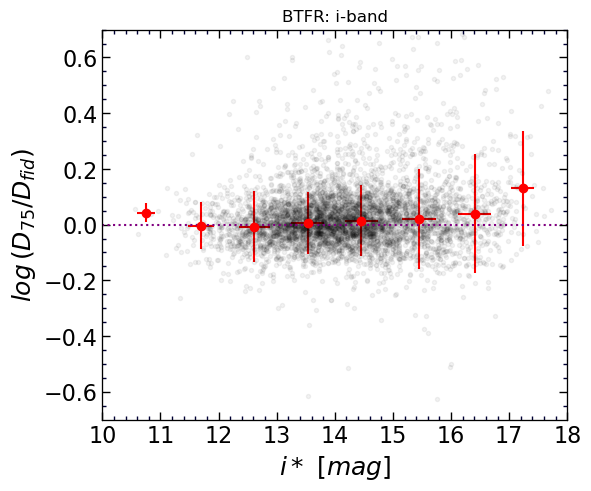

In [17]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff_['i***'].values
Y = dff_.dDM.values/5.
V = dff_.Vmod.values

# Y=Y[V>4000]
# X=X[V>4000]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-0.7,0.7))

ax.set_title("BTFR: i-band")

In [80]:
logMs = 1.685 + 0.359*df.gi - 0.4*df['Mi_75'] ### ~> 2.10
df['logMs'] = logMs
df['Mass_star'] = 10**logMs
df['Mb'] = df['Mass_star'] + 1.33*df['Mass_HI']
df['logMass'] = np.log10(df.Mb.values)

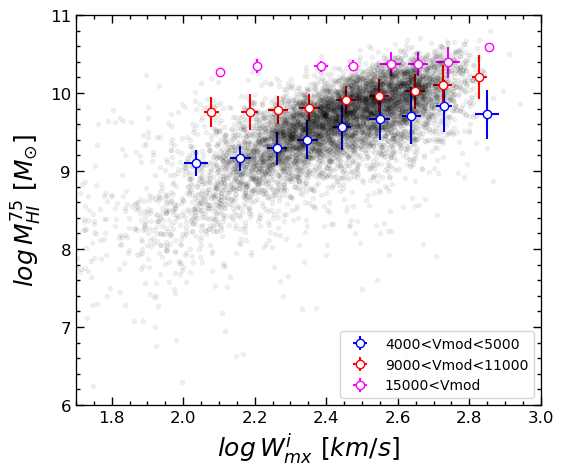

In [97]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)].dropna()
X0 = dff.lgWmxi.values
Y0 = np.log10(dff.Mass_HI.values)
# Y0 = dff.logMass.values
# Y0 = dff.logMs.values
Vmod = dff.Vmod.values

ax.plot(X0, Y0, 'k.', alpha=0.05)

label='4000<Vmod<5000'
ind, = np.where((Vmod>4000)&(Vmod<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(2,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label='9000<Vmod<11000'
lab = True
ind, = np.where((Vmod>9000)&(Vmod<11000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)            
        
        
label='15000<Vmod'
lab = True
ind, = np.where((Vmod>9000)&(Vmod<11000))
X = X0[ind]
Y = Y0[ind]        
ind, = np.where((Vmod>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='magenta', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{HI}^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (6,11), fontsize=12)

ax.legend()

(<AxesSubplot:label='33a3bf98-697d-4a7d-b73f-42f4e86ec477'>,
 <AxesSubplot:label='286c6096-c95a-4e61-9503-6c6dcbff2f57'>)

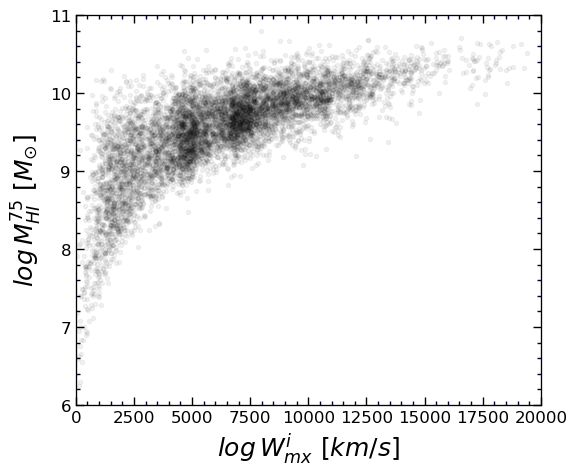

In [95]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)].dropna()
X0 = dff.lgWmxi.values
Y0 = np.log10(dff.Mass_HI.values)
# Y0 = dff.logMass.values
# Y0 = dff.logMs.values
Vmod = dff.Vmod.values

ax.plot(Vmod, Y0, 'k.', alpha=0.05)




ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{HI}^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (0,20000), (6,11), fontsize=12)